## Gait Analysis from IMUs

<div style="text-align: center;">
<img src='gaitIMUS.png' alt='gait IMUs'>
</div>


In this notebook, we will use data collected with Inertial Measurements Unit (IMU) located around the center of mass during gait.

The overall objectives are to learn how to 
- Visualize acceleratio data recorded during gait 
- Detect gait events from acceleration data 
- Re-structure your data using interporlation to analyze relevant gait biomechanics 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks
from scipy.interpolate import interp1d

In [4]:
#the data contains the time time vector and acceleration (x,y, and z) 
data = pd.read_csv('data/accelerationSteps.csv', index_col=None)
data.head()

,time,z,y,x
0,0.000000,-1.063303,-0.129520,-0.508230
1,0.010005,-1.040474,0.026074,-0.266110
2,0.020010,-1.035832,0.170286,-0.062972
3,0.030015,-1.064030,0.352063,0.209522
4,0.040020,-1.110660,0.475886,0.433908


Text(0, 0.5, 'z-Acceleration')

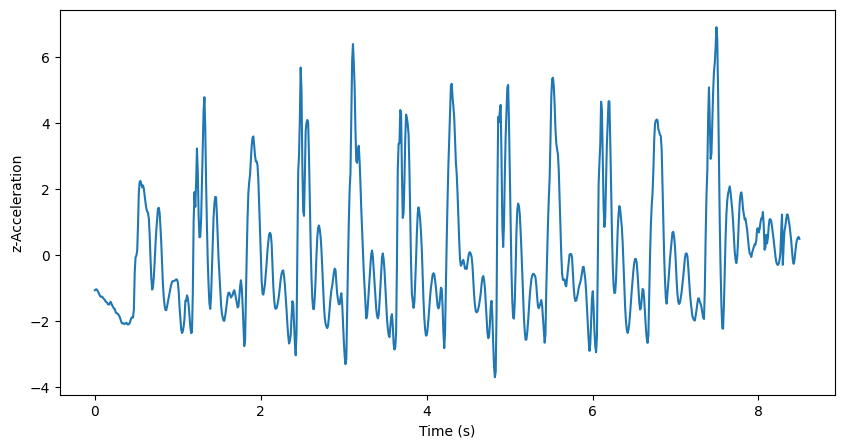

In [5]:

plt.figure(figsize=(10,5))
plt.plot(data['time'], data['z'])
plt.xlabel('Time (s)')
plt.ylabel('z-Acceleration')

As you can see, this signal has some drift (red line) and the peak of acceleration are not well defined (double peaks). We need to remove elements from the acceleration signal that are not useful for our analysis. 

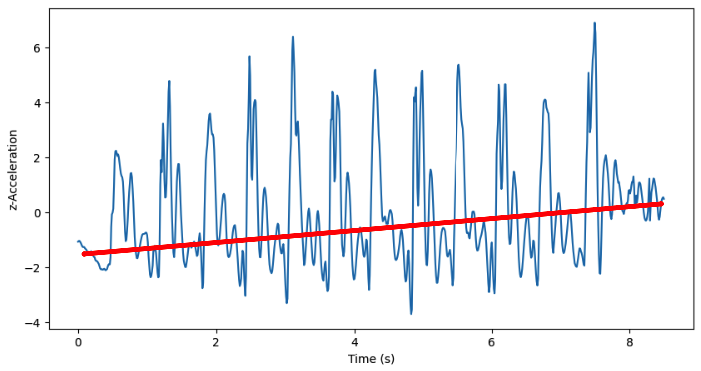

The average sampling rate is 99.95002498750583


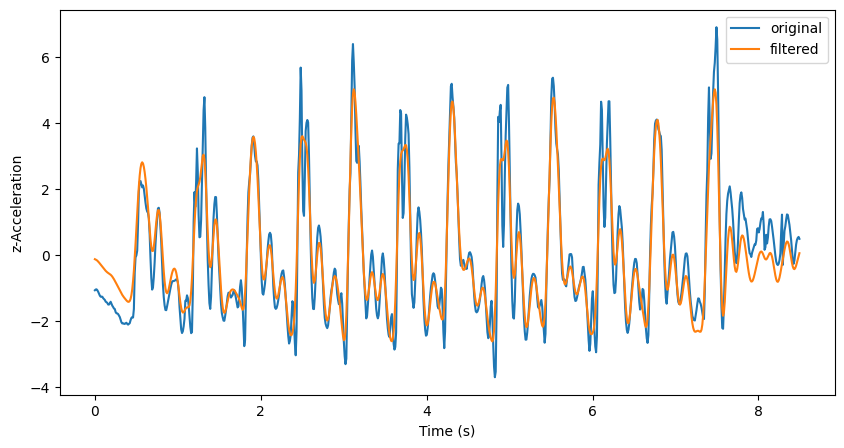

In [6]:
#we will filter (remove parts that we don't want) the signal 
#for gait, we can remove all components that are not physiologically relevant. We will remove component below 0.5 Hz and above 7 Hz
#note that for other activities, like running, these values need to be adjusted. 

#finding the sampling rate (ie. how many samples in a second)
fs = 1/np.median(np.diff(data['time']))
print(f'The average sampling rate is {fs}')

#designing and applying a filter with the desired cutoffs
low_cf = 0.5 / (fs/2)
high_cf = 7 / (fs/2)
b, a = butter(2, [low_cf, high_cf], btype='bandpass')
z_filt = filtfilt(b,a,data['z'])
time = data['time'].values

plt.figure(figsize=(10,5))
plt.plot(time, data['z'], label='original')
plt.plot(time, z_filt, label='filtered')
plt.xlabel('Time (s)')
plt.ylabel('z-Acceleration')
plt.legend()

Now, we can use the acceleration data to detect steps, this can be achieved by detecting the different heel strikes in the acceleration data. The heel strikes correspond to the peaks in the acceleration signal, this is the moment when the maximum acceleation (you heel hits the ground) occurs. 


We can find the peak using the function `find_peaks` from the `scipy` libraby. 


Text(0, 0.5, 'z-Acceleration')

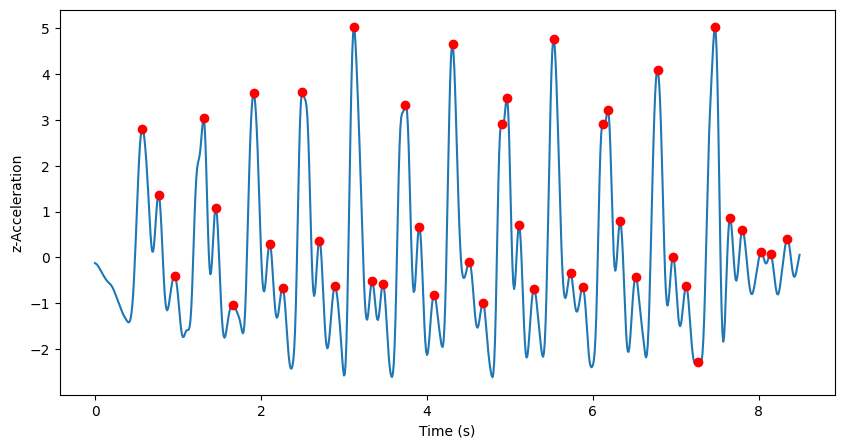

In [7]:
peaks, val = find_peaks(z_filt)
plt.figure(figsize=(10,5))
plt.plot(time, z_filt)
plt.plot(time[peaks], z_filt[peaks], 'o', color = 'red')
plt.xlabel('Time (s)')
plt.ylabel('z-Acceleration')

As you can see, this function found **ALL** the peaks in the data, which is not very useful. We can restric the peaks by using information about the peak height and time between peaks. 

In this case, we only want peaks above 1, and want peaks at are at least 0.5 seconds appart.

The `distance` must be given in index, not in time, so we need to transform the 0.5s to index, as

```python
distance = int(0.5 * fs)
```

Text(0, 0.5, 'z-Acceleration')

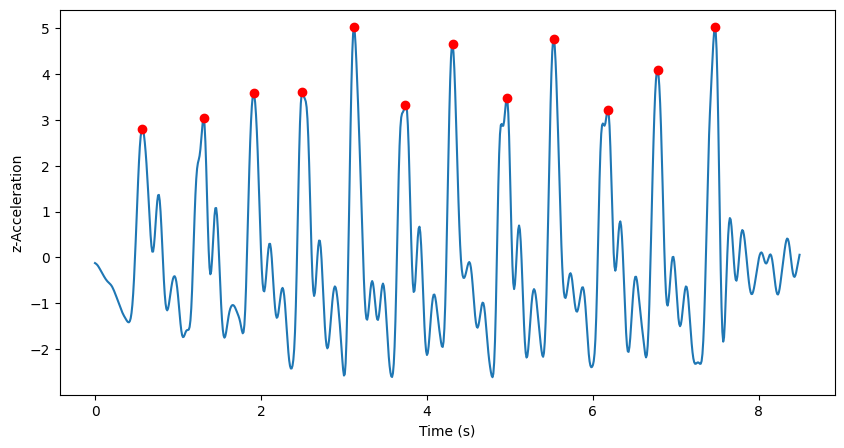

In [9]:
distance = int(0.5 * fs)
peaks, val = find_peaks(z_filt, height=1, distance = distance)
plt.figure(figsize=(10,5))
plt.plot(time, z_filt)
plt.plot(time[peaks], z_filt[peaks], 'o', color = 'red')
plt.xlabel('Time (s)')
plt.ylabel('z-Acceleration')

Great, we found the peaks in the acceleration signal!

Each peak should correspond to a heel strike, so we can visualize what happends during each stride.


<div style="text-align: center;">
<img src='gaitEvents.png' alt='gait IMUs'>
</div>


We can now plot each segment so and analyze each step or stride.

Text(0, 0.5, 'z-Acceleration')

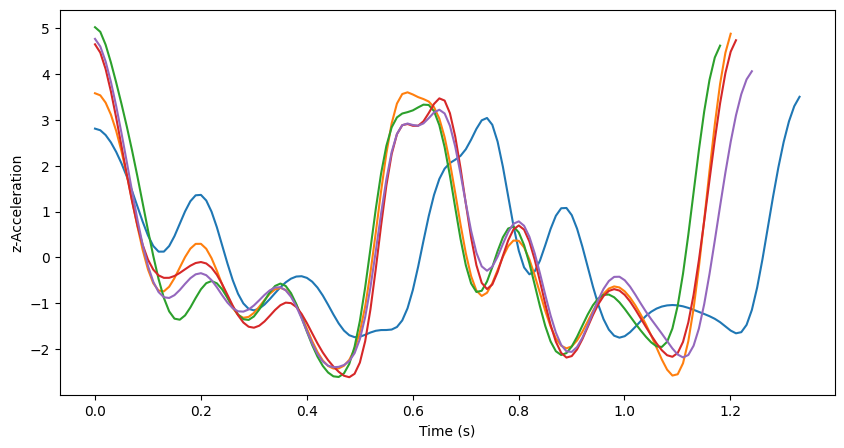

In [10]:
#lets plot the acceleration recorded at each stride

plt.figure(figsize=(10,5))
segments = []
for i in range(0,len(peaks)-2,2):
    start_index = peaks[i]
    end_index = peaks[i+2]

    duration = time[start_index:end_index] 
    #assure that each step last at least 0.5 secods
    if (duration[-1] - duration[0])>=0.5:
        segments.append(z_filt[start_index:end_index])
        plt.plot(duration-duration[0], segments[-1])

plt.xlabel('Time (s)')
plt.ylabel('z-Acceleration')


We have a problem, the steps have a slightly different duration, so we cannot analyze how the acceleration changes during gait...


The solution is to change our x-axis from time (in seconds) to stride phase (in %) so that each all the strides occur betwen 0 and 100% of the stride phase.

There are many alteratives to achieve this time normalization. For simplicity, we will use linear interpolation. That is we will create a new time vector with 101 elements (from 0 to 100) and will use linear regression to find the values of the z-acceleration for the new time vector.



Text(0, 0.5, 'z-Acceleration')

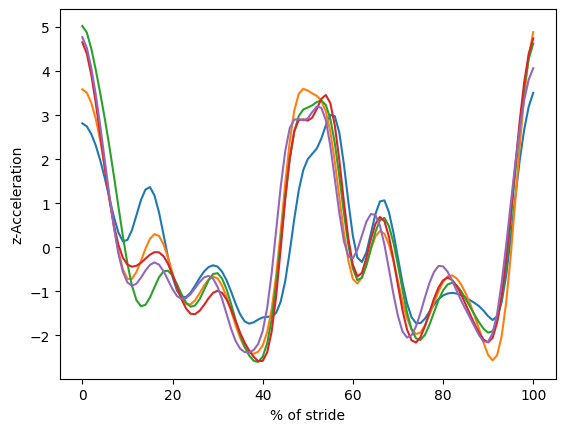

In [11]:
#time normalization 
segments_normalized = []
segments = []
for i in range(0,len(peaks)-2,2):
    start_index = peaks[i]
    end_index = peaks[i+2]

    duration = time[start_index:end_index] 
    #assure that each step last at least 0.5 secods
    if (duration[-1] - duration[0])>=0.5:

        original = np.linspace(0,100,len(duration))
        target = np.linspace(0, 100, 101)
        iterpolator = interp1d(original, z_filt[start_index:end_index],kind='linear')
        segments_normalized.append(iterpolator(target))
        plt.plot(target, segments_normalized[-1])

plt.xlabel("% of stride")
plt.ylabel('z-Acceleration')

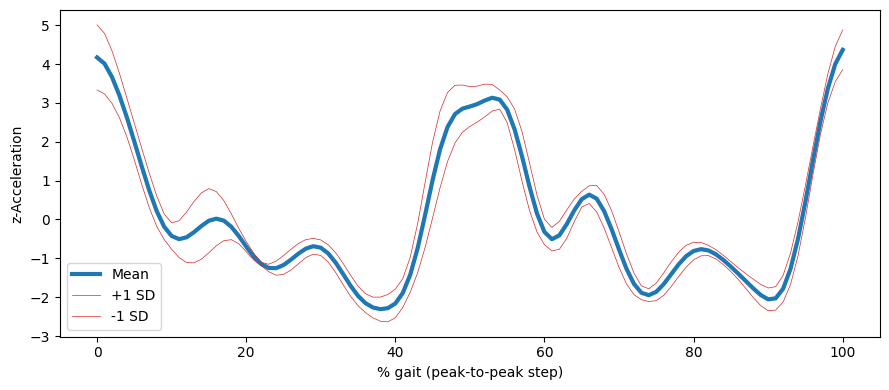

In [12]:
#now we can plot the group mean and standar deviations
segments_normalized = np.array(segments_normalized)
normalized_time = np.linspace(0, 100, 101)

plt.figure(figsize=(9, 4))

# plot individual steps lightly (shows variability)
mean_gait = segments_normalized.mean(axis=0)
std_gait = segments_normalized.std(axis=0)
# plot mean and SD band as lines (students can see it clearly)
plt.plot(normalized_time, mean_gait, linewidth=3, label="Mean")
plt.plot(normalized_time, mean_gait + std_gait, color = "tab:red", linewidth=0.5, label="+1 SD")
plt.plot(normalized_time, mean_gait - std_gait, color = "tab:red", linewidth=0.5, label="-1 SD")

plt.xlabel("% gait (peak-to-peak step)")
plt.ylabel("z-Acceleration")
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
#from the acceleration signal, we can also obtain useful information, as:

#number of steps:
NumberOfStep = len(peaks)
print(f'Number of Steps = {NumberOfStep}')

#cadence
Duration = time[peaks[-1]] - time[peaks[0]]
print(f'Cadence = {(NumberOfStep/Duration)*60:.3f} steps per minute')

#average step duration
StepDuration = np.diff(time[peaks])
print(f'Average Step Duration = {np.mean(StepDuration):.3f} seconds')

#step duration variability
print(f'Step Duration Variability = {np.std(StepDuration):.3f} seconds')

#Average Stride duration
StrideDuration = np.diff(time[peaks[::2]])
print(f'Average Step Duration = {np.mean(StrideDuration):.3f} seconds')

#Stride duration variability
print(f'Step Duration Variability = {np.std(StrideDuration):.3f} seconds')



Number of Steps = 12
Cadence = 104.295 steps per minute
Average Step Duration = 0.628 seconds
Step Duration Variability = 0.050 seconds
Average Step Duration = 1.243 seconds
Step Duration Variability = 0.053 seconds
